#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [5]:
# загрузим необходимые библиотеки

import pandas as pd

import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose

import numpy as np

from sklearn.model_selection import train_test_split

from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.linear_model import LinearRegression

from sklearn.tree import DecisionTreeRegressor

from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_squared_error

from sklearn.model_selection import TimeSeriesSplit

from sklearn.dummy import DummyRegressor

In [6]:
# прочитаем данные 

def data_reading(path):
    data = pd.read_csv(path)
    print(f'Информация о данных: \n')
    data.info()
    print(f'\nКоличество дубликатов: {data.duplicated().sum()} \n')
    print(f'\nДоля дубликатов: {data.duplicated().mean()}\n')
    print(f'\nКоличество пропусков:\n\
{data.isna().sum()} \n')
    print(f'\nДоля пропусков:\n\
{data.isna().mean()} \n')
    print(f'Первые 5 строк датасета: \n')
    display(data.head(5))
    return data

In [9]:
data = data_reading('taxi.csv')

Информация о данных: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB

Количество дубликатов: 0 


Доля дубликатов: 0.0


Количество пропусков:
datetime      0
num_orders    0
dtype: int64 


Доля пропусков:
datetime      0.0
num_orders    0.0
dtype: float64 

Первые 5 строк датасета: 



,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


In [10]:
# заменим тип данных столбца datetime на временной

data['datetime'] = pd.to_datetime(data['datetime'])

# выберем индексом временной столбец
data = data.set_index(data['datetime'])
data = data.drop(columns = ['datetime'], axis = 1)
data = data.sort_index()


In [11]:
# проверка на монотонность
data.index.is_monotonic

/var/folders/wd/gl0hh07s1f73kj7kynty4z6r0000gn/T/ipykernel_68039/1892999633.py:2: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  data.index.is_monotonic


True

In [12]:
# оценим итоговый датасет
data

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
...,...
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27


Тип данных столбца datetime был изменен на временной.

После чего в исходном датасете индексы были изменены на значения из временного столбца и отсортированы в порядке возрастания.

Более детальной предобработки данных не требуется, поэтому можно приступать к следующему этапу

## Анализ

<Axes: title={'center': 'Зависимость количества заказов от времени'}, xlabel='datetime'>

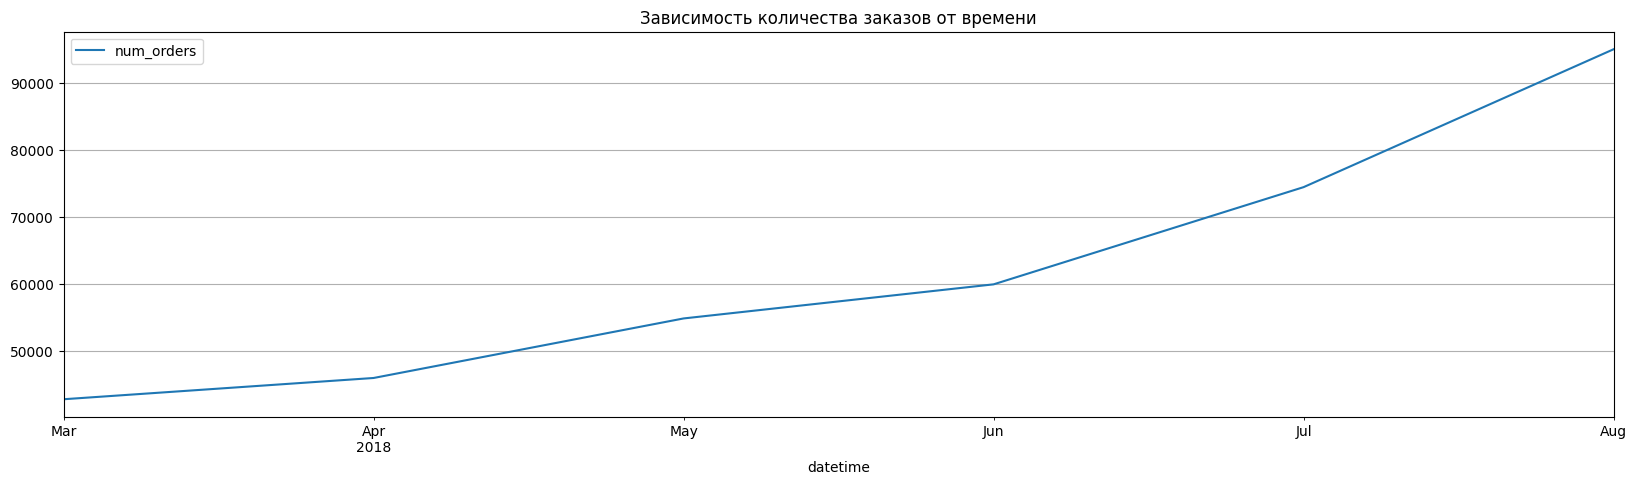

In [13]:
# зависимость количечства заказов от времени

data.resample('1M').sum().plot(title = 'Зависимость количества заказов от времени', 
                               grid = True, 
                               figsize = (20,5),
                               ax = plt.gca())

<Axes: title={'center': 'Дневной тренд'}, xlabel='datetime'>

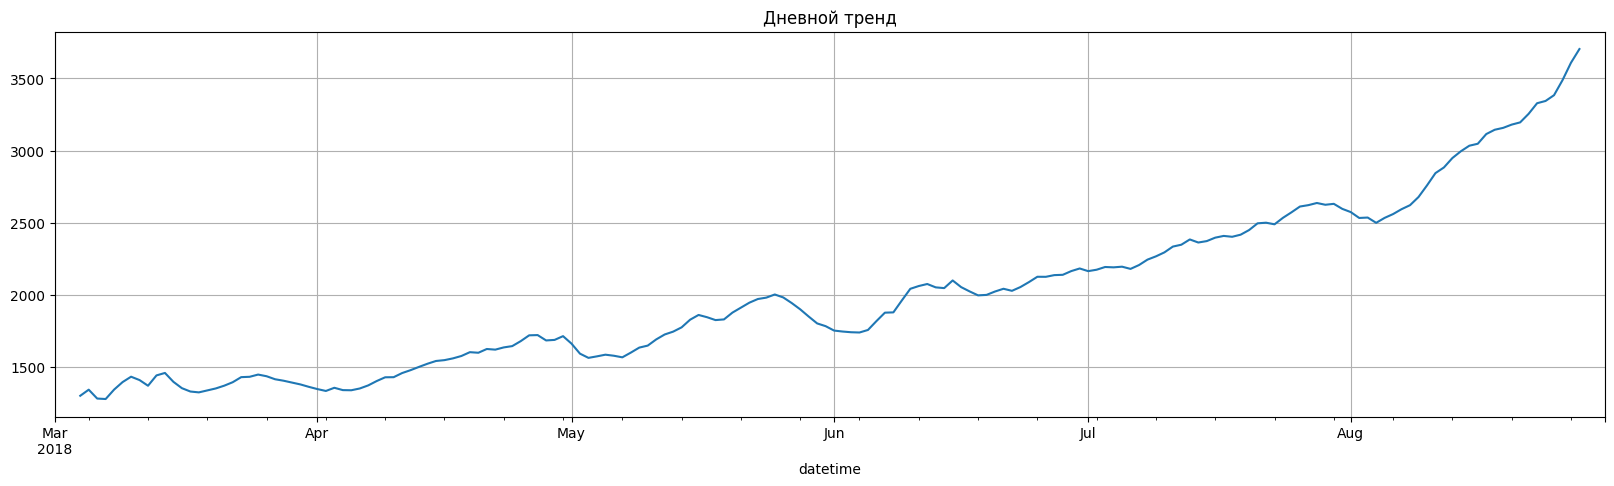

In [14]:
seasonal_decompose(data.resample('1D').sum()).trend.plot(title = 'Дневной тренд',
                                                         figsize=(20,5), 
                                                         grid = True, 
                                                         ax=plt.gca())

<Axes: title={'center': 'Зависимость количества заказов от времени'}, xlabel='datetime'>

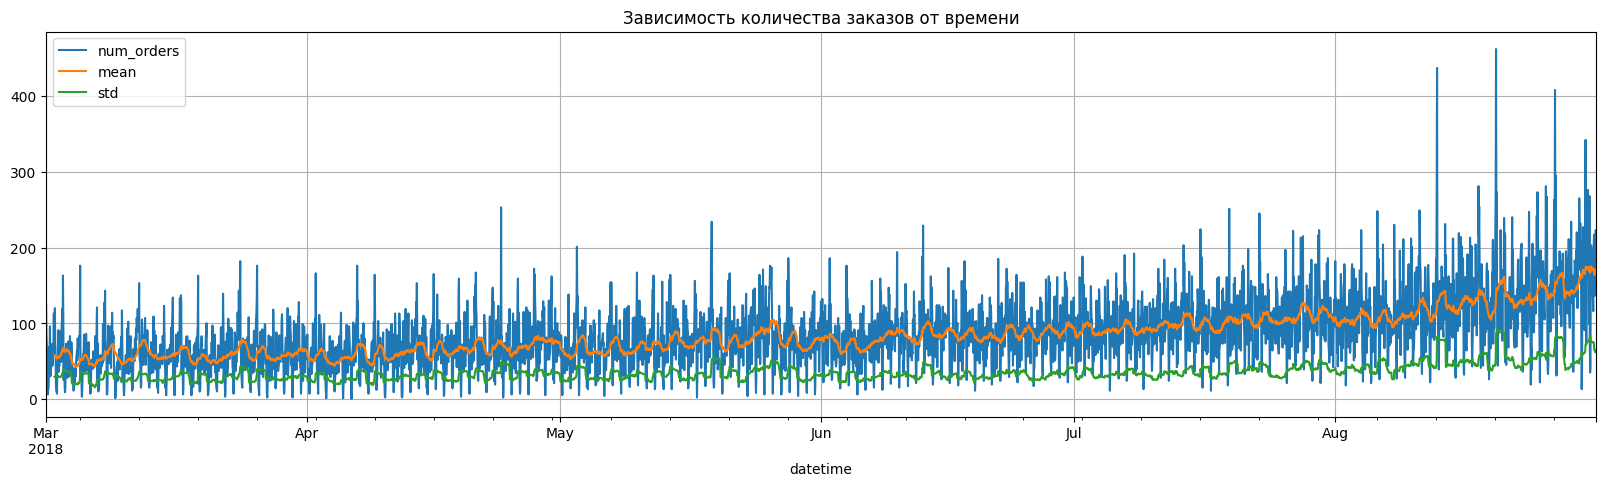

In [15]:
# скользящее среднее и скользящее стандартное 

hour_statistic = data.resample('1H').sum()
hour_statistic['mean'] = hour_statistic['num_orders'].rolling(25).mean()
hour_statistic['std'] = hour_statistic['num_orders'].rolling(25).std()
hour_statistic.plot(title = 'Зависимость количества заказов от времени',
                    grid = True, 
                    figsize = (20,5))

<Axes: title={'center': 'Сезонность'}, xlabel='datetime'>

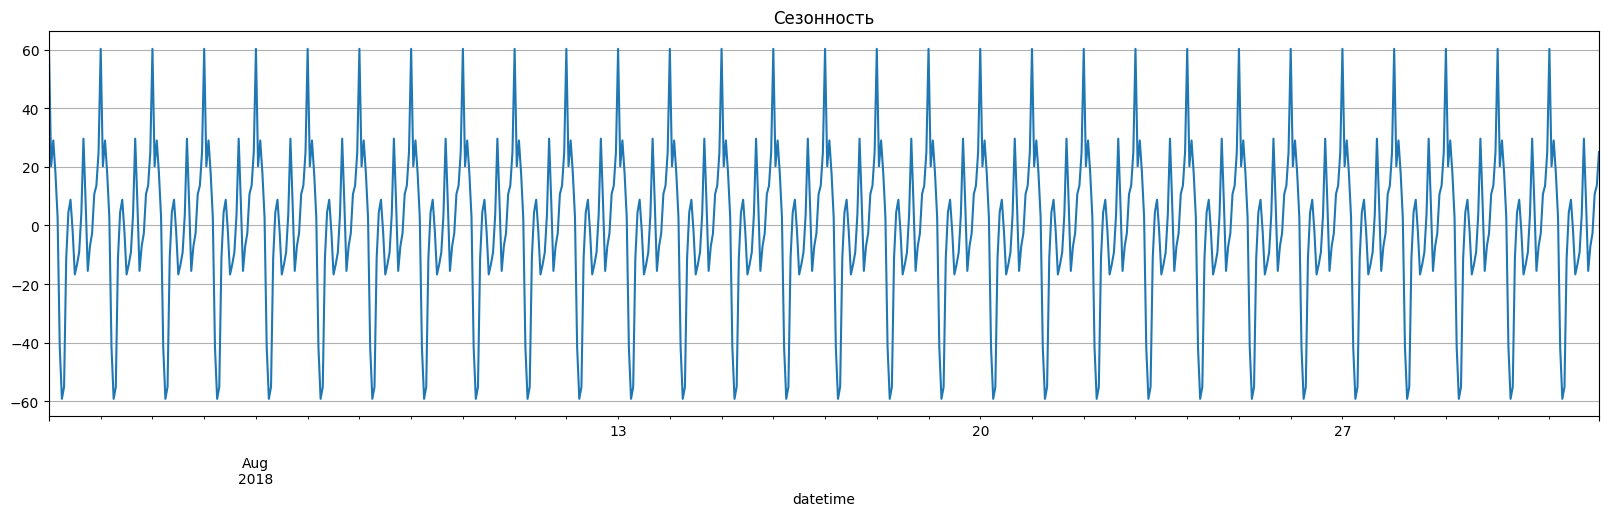

In [16]:
# построим сезонность в масштабе 1 час

seasonal_decompose(data.resample('1H').sum()).seasonal.tail(24*30).plot(title='Сезонность',
                                                                        figsize=(20,5), 
                                                                        grid = True, 
                                                                        ax=plt.gca())

<Axes: title={'center': 'Сезонность'}, xlabel='datetime'>

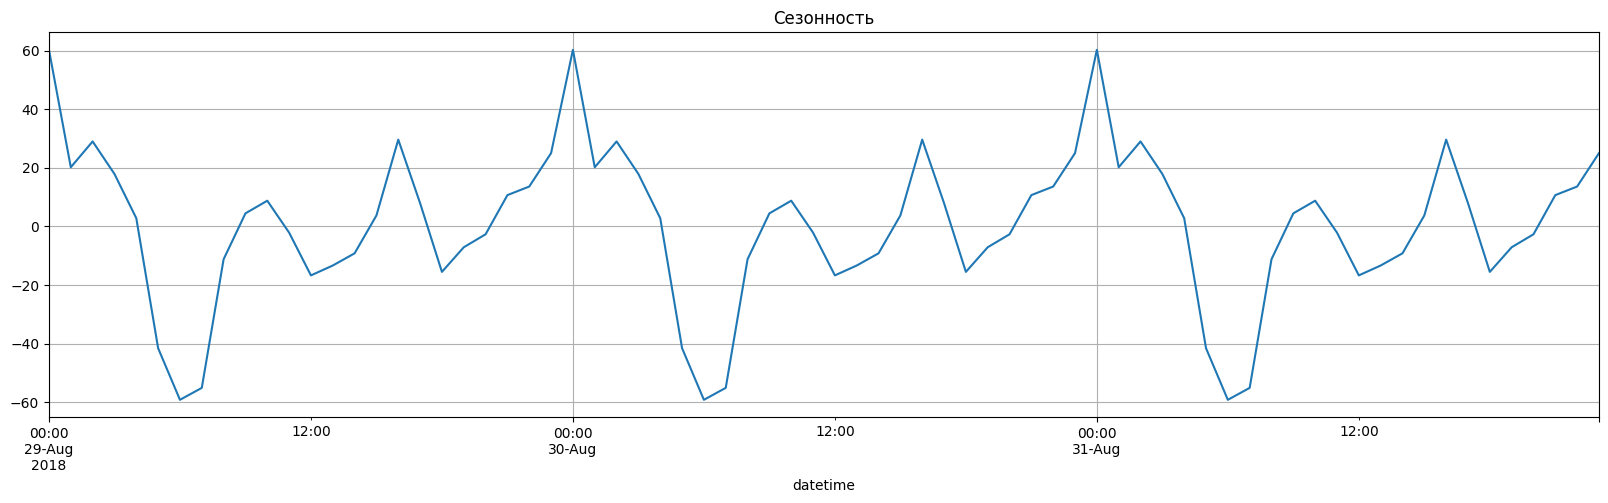

In [17]:
# выберем срез за 3 крайних дня

seasonal_decompose(data.resample('1H').sum()).seasonal.tail(24*3).plot(title='Сезонность',
                                                                       figsize=(20,5),
                                                                       grid = True, 
                                                                       ax=plt.gca())

Анализ показал, что количество заказов плавно растет каждый месяц (при часовом ресемпле имеются периодические просадки, но тренд все равно восходящий). 

Сезонность отражает дневную цикличность

## Обучение

In [18]:
# сделаем ресемплирование по 1 часу (согласно заданию)

data = data.resample('1H').sum()

In [19]:
# создадим функцию признаков

def make_features(data, max_lag, rolling_mean_size):
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['hour'] = data.index.hour
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

<div class="alert alert-block alert-info">
<b>Совет: </b> Желательно было написать функцию таким образом, чтобы она возвращала новый датафрейм, а не изменяла глобальную переменную.
</div>

In [20]:
# создаем тренировочную и тестовую выборки

make_features(data, 24, 48)

train, test = train_test_split(data, shuffle=False, test_size=0.1)
train = train.dropna()

features_train = train.drop('num_orders', axis = 1)
target_train = train['num_orders']

features_test = test.drop('num_orders', axis = 1)
target_test = test['num_orders']


In [22]:
# оценим полученные выборки признаков

display(features_train.head())
display(features_test.head())

,month,day,hour,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-03 00:00:00,3,3,0,5,72.0,119.0,101.0,93.0,49.0,89.0,...,46.0,7.0,11.0,11.0,20.0,64.0,75.0,120.0,90.0,59.791667
2018-03-03 01:00:00,3,3,1,5,163.0,72.0,119.0,101.0,93.0,49.0,...,45.0,46.0,7.0,11.0,11.0,20.0,64.0,75.0,120.0,60.604167
2018-03-03 02:00:00,3,3,2,5,108.0,163.0,72.0,119.0,101.0,93.0,...,54.0,45.0,46.0,7.0,11.0,11.0,20.0,64.0,75.0,61.083333
2018-03-03 03:00:00,3,3,3,5,25.0,108.0,163.0,72.0,119.0,101.0,...,91.0,54.0,45.0,46.0,7.0,11.0,11.0,20.0,64.0,60.125000
2018-03-03 04:00:00,3,3,4,5,64.0,25.0,108.0,163.0,72.0,119.0,...,36.0,91.0,54.0,45.0,46.0,7.0,11.0,11.0,20.0,60.083333


,month,day,hour,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-08-13 14:00:00,8,13,14,0,119.0,92.0,144.0,156.0,137.0,91.0,...,118.0,135.0,98.0,82.0,78.0,115.0,153.0,149.0,104.0,123.395833
2018-08-13 15:00:00,8,13,15,0,102.0,119.0,92.0,144.0,156.0,137.0,...,185.0,118.0,135.0,98.0,82.0,78.0,115.0,153.0,149.0,124.000000
2018-08-13 16:00:00,8,13,16,0,175.0,102.0,119.0,92.0,144.0,156.0,...,160.0,185.0,118.0,135.0,98.0,82.0,78.0,115.0,153.0,124.666667
2018-08-13 17:00:00,8,13,17,0,144.0,175.0,102.0,119.0,92.0,144.0,...,273.0,160.0,185.0,118.0,135.0,98.0,82.0,78.0,115.0,124.041667
2018-08-13 18:00:00,8,13,18,0,152.0,144.0,175.0,102.0,119.0,92.0,...,437.0,273.0,160.0,185.0,118.0,135.0,98.0,82.0,78.0,124.666667


In [23]:
# для кросс-валидации временных признаков воспользуемся TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=4)

In [26]:
# линейная регрессия

parameters = {'fit_intercept': [True, False] }
model_lr = LinearRegression(n_jobs = -1)
grid_searching = GridSearchCV(model_lr, parameters, scoring = 'neg_root_mean_squared_error', cv=tscv)
grid_searching.fit(features_train, target_train)
print('Лучшие параметры модели:', grid_searching.best_params_)
print('Лучшее значение RMSE:', (-1)*grid_searching.best_score_)

Лучшие параметры модели: {'fit_intercept': False}
Лучшее значение RMSE: 27.05509167441458


<div class="alert alert-block alert-success">
<b>Успех:</b> Отлично, что для подбора параметров использовался метод основанный на кросс-валидации с подходящим под данные сплиттером.
</div>

In [27]:
# дерево решений

parameters = {'max_depth': range (1, 50, 2) }
model_dt = DecisionTreeRegressor()
grid_searching = GridSearchCV(model_dt, parameters, scoring = 'neg_root_mean_squared_error', cv=tscv)
grid_searching.fit(features_train, target_train)
print('Лучшие параметры модели:', grid_searching.best_params_)
print('Лучшее значение RMSE:', (-1)*grid_searching.best_score_)

Лучшие параметры модели: {'max_depth': 5}
Лучшее значение RMSE: 30.71379067418663


In [28]:
# случайный лес

parameters = {'max_depth': range (1, 50, 10), 'n_estimators': range(1,50, 10) }
model_rf = RandomForestRegressor(n_jobs = -1)
grid_searching = GridSearchCV(model_rf, parameters, scoring = 'neg_root_mean_squared_error', cv=tscv)
grid_searching.fit(features_train, target_train)
print('Лучшие параметры модели:', grid_searching.best_params_)
print('Лучшее значение RMSE:', (-1)*grid_searching.best_score_)

Лучшие параметры модели: {'max_depth': 41, 'n_estimators': 41}
Лучшее значение RMSE: 25.971996630459294


Для исследования были использованы модели линейной регрессии, случайного леса и дерева решений.

Моделируя на тренировочных выборках, лучшие результаты показала модель случайного леса, поэтому выберем эту модель для дальнейшего тестирования

## Тестирование

In [29]:
# тестирование на модели случайного леса

model_rf  = RandomForestRegressor(n_jobs = -1,
                                  max_depth = 31,
                                  n_estimators = 41)

model_rf.fit(features_train, target_train)

print(f'RMSE тестовой модели:{mean_squared_error(target_test, model_rf.predict(features_test), squared = False)}')

RMSE тестовой модели:43.612155070949164


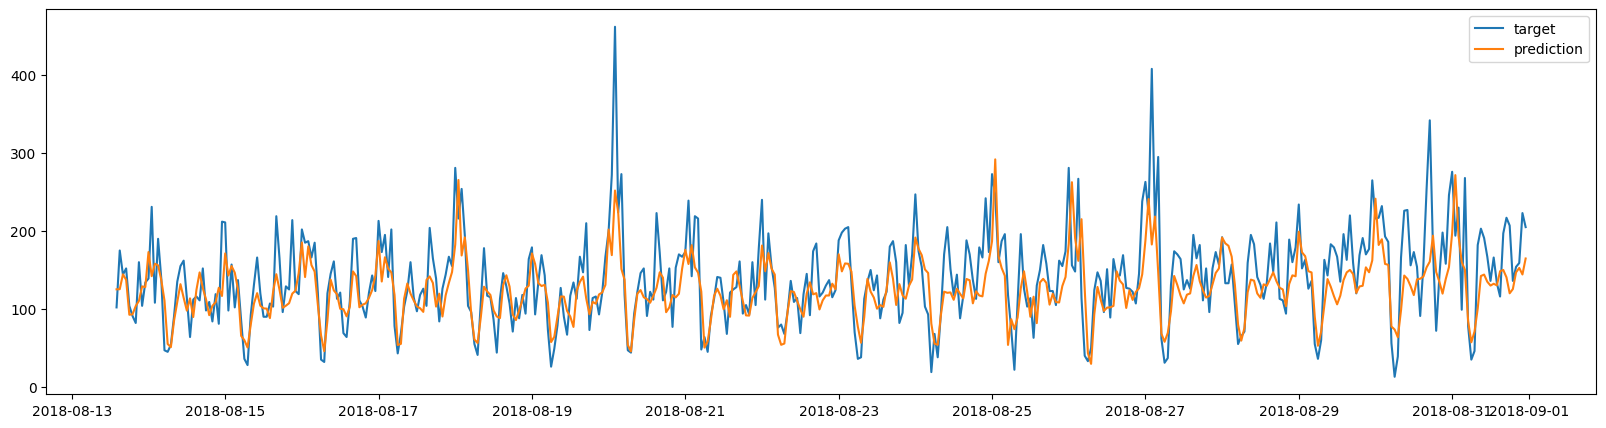

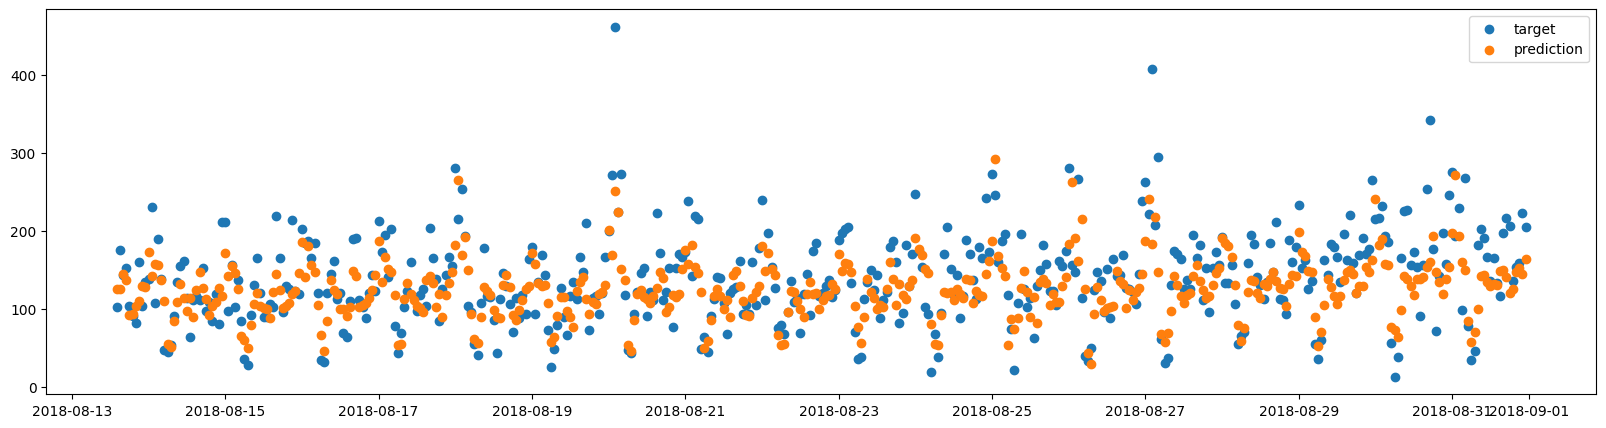

In [30]:
# визуализируем предсказание с целевыми значениями  

plt.figure(figsize=(20, 5))

plt.plot(target_test.index, target_test, label = 'target')
plt.plot(target_test.index, model_rf.predict(features_test), label = 'prediction')
plt.legend()

plt.show()


plt.figure(figsize=(20, 5))

plt.scatter(target_test.index, target_test, label = 'target')
plt.scatter(target_test.index, model_rf.predict(features_test), label = 'prediction')
plt.legend()
plt.show()

Согласно результатам тестирования, требуемое значение RMSE менее 48 было достигнуто.

Также результаты были представлены графически, где наблюдается достаточная видимость "наложения" прогнозных значений на целевые

In [31]:
# сравним результаты с наивной моделью

dummy_model = DummyRegressor(strategy='mean')

dummy_model.fit(features_train, target_train)

print('rmse наивной модели:', mean_squared_error(target_test, dummy_model.predict(features_test), squared = False))

rmse наивной модели: 84.5807770460722


Значение метрики rmse много хуже значения соответствующей метрики нашей модели, что говорит об адекватности полученных ранее результатов